
# Laboratorium 6: Segmentacja 3D (MRI) — architektura typu V-Net


W tym ćwiczeniu również zajmiemy się problemem **segmentacji semantycznej** obszarów hipokampu, lecz tym razem dla danych trójwymiarowych za pomocą architektury typu **V-Net**.

**Cele zajęć**
- Wczytanie danych trójwymiarowych i sprawdzenie ich formatu.
- Wykorzystanie **MONAI** do wczytywania i przetwarzania wstępnego danych 3D.
- Trening sieci za pomocą losowych voxeli 3D.
- Poznanie architektury typu **V-Net** oraz czym różni się od **U-Net**.
- Wykonanie segmentacji danych trójwymiarowych oraz sprawdzenie skuteczności rozwiązania.

**Dataset:**  
Użyjemy **MSD Task04 Hippocampus** — zbioru MRI z adnotacjami hipokampa pochodzącego z Medical Segmentation Decathlon. Zawiera on około ~260 skanów z maskami (etykiety: 0 = tło, 1 = anterior hippocampus, 2 = posterior hippocampus). Dane zostaną automatycznie pobrane przez MONAI (`DecathlonDataset`). W notebooku dodatkowo przeprowadzamy: izotropizację do 1×1×1 mm, normalizację intensywności, oraz ekstrakcję 3D‑patchy z kontrolowanym stosunkiem próbek pozytywnych/negatywnych.

## 0) Instalacja i importy

Jeśli chcemy powtarzalnych wyników możemy ustawić stały SEED.

In [1]:

# !pip -q install monai-weekly pytorch-lightning torchmetrics nibabel scikit-image --extra-index-url https://download.pytorch.org/whl/cpu

import os, tarfile, urllib.request, random, glob, math, json
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F
# from torch.utils.data import DataLoader
from monai.data import DataLoader


from monai.apps import download_and_extract
from monai.data import CacheDataset, Dataset, decollate_batch, list_data_collate
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd,
    NormalizeIntensityd, RandSpatialCropd, RandCropByPosNegLabeld,
    RandFlipd, RandRotate90d, EnsureTyped, EnsureType, AsDiscrete,
    CenterSpatialCropd
)
from monai.networks.nets import VNet
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference

from monai.apps import DecathlonDataset
from pathlib import Path
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd, NormalizeIntensityd, RandCropByPosNegLabeld, RandFlipd, RandRotate90d, EnsureTyped, CenterSpatialCropd, SpatialPadd

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, LightningDataModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from torchmetrics.classification import MulticlassJaccardIndex

# SEED = 42
SEED = None
def set_seed(s=SEED):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)

if SEED is not None:
    set_seed()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device, '| Lightning:', pl.__version__)


Device: cuda | Lightning: 2.5.5


## Zadanie 1 – Konfiguracja parametrów, pobranie danych i przetwarzanie wstępne 

W tym zadaniu przygotujemy dane uczące i walidacyjne wykorzystując funkcje i transformacje z biblioteki MONAI. Parametry zostały już zdefiniowane w komórce z kodem poniżej. 4 pierwsze parametry są oczywiste, natomiast warto wyjaśnić znaczenie drugiej połowy.
- `ROI_SIZE` - rozmiar wycinanych patchy 3D. Zamiast przetwarzać całą pojedynczą próbkę danych, dla trójwymiarowych częstym podejściem jest wycinanie z nich fragmentu (ROI) o zadanym rozmiarze i traktowanie tego ROI jako pojedynczej próbki.
- `SAMPLES_PER_VOLUME` — liczba patchy pobieranych z jednego wolumenu uczącego dla każdej próbki w każdej epoce treningu. Zwiększenie wartości generuje więcej przykładów treningowych z każdego skanu (więcej wariancji), ale też zwiększa czas przetwarzania.
- `POS_NEG_RATIO` — stosunek patchy wokół "piksela" pozytywnego (o masce większej od 0) do patchy wokół "piksela" negatywnego (należącego do tła) wybranych dla każdego przykładu treningowego. Przy małych obiektach (np. hipokamp) losowe ROI ma małe szanse trafić na obiekt, więc takie losowanie pozwala lepiej nauczyć model rozpoznawania struktur zamiast przeuczenia na tle.
- `BATCH_SIZE` — liczba próbek w batchu podczas treningu (jak we wcześniejszych ćwiczeniach). Jednak tutaj ten parametr należy rozważać wspólnie z `SAMPLES_PER_VOLUME`. Najpierw wybierane jest `BATCH_SIZE` próbek ze zbioru danych, a następnie z każdej pobranej próbki pobierane jest `SAMPLES_PER_VOLUME` patchy o rozmiarze `ROI_SIZE`.

Dlaczego stosujemy wycinanie patchy i opisane transformacje?
- Efektywność pamięci i obliczeń: przetwarzanie pełnych wolumenów 3D jest zwykle bardzo kosztowne (pamięć GPU), dlatego uczymy na mniejszych patch'ach. Jest to szczególnie ważne dla zbiorów o dużych rozdzielczościach.
- Zwiększenie liczby próbek: z jednego wolumenu możemy uzyskać wiele niezależnych patchy, co pomaga w trenowaniu (więcej różnych widoków/położeń struktury).
- Radzenie sobie z nierównomiernym rozkładem klas: przez kontrolę pos/neg można wymusić, żeby model widywał wystarczająco dużo przykładów rzadkich klas.
- Możliwość wykonywania obliczeń dla danych wejściowych o różnych rozmiarach.

Należy również zauważyć, że wykorzystywany dataset ma tylko dwa podzbiory: treningowy i walidacyjny. Można ten problem rozwiązać na 2 sposoby. Pierwszym jest traktowanie zbioru walidacyjnego zarówno jako zbiór testowy. Drugim jest wydzielenie zbioru testowego ze zbioru walidacyjnego. W naszym rozwiązaniu wykorzystamy to pierwsze podejście.

1. Zdefinujmy 3 listy transformacji: `pre_transforms`, `train_transforms` i `val_transforms`.
2. `pre_transforms` jest listą, która zawiera początkowe przekształcenia, wykonywane są dla wszystkich wczytywanych danych:
   - `LoadImaged(keys=["image", "label"])` - wczytuje dane w formacie 'NIfTI' oraz odpowiadającą im maskę segmentacji,
   - `EnsureChannelFirstd(keys=["image", "label"])` - zapewnienie że kanał jest pierwszym wymiarem,
   - `Orientationd(keys=["image", "label"], axcodes="RAS")` - orientacja do standardowego układu RAS (Right-Anterior-Superior),
   - `Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest"))` - izotropizacja voxeli do 1×1×1 mm, odpowiednio metodą biliniową dla danych uczących i metodą najbliższego sąsiada dla maski segmentacji,
   - `NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True)` - normalizacja intensywności MRI
3. Stwórz `train_transforms` za pomocą funkcji `Compose`, której argumentem jest lista transformacji. Na jej początku znajdować się powinny elementy z `pre_transforms`, a następnie dodatkowe augmentacje:
   - `RandCropByPosNegLabeld` - losowe wycinanie patchy 3D z kontrolą pos/neg (parametry: `keys=["image", "label"]`, `image_key="image`, `label_key="label"`, `spatial_size` (rozmiar patch'y), `pos` (część patch'y wokół pikseli pozytywnych), `neg` (część patchy wokół pikseli negatywnych), `num_samples` (liczba patch'y dla każdej próbki)),
   - `RandFlipd` x2 - losowe odbicie z zadanym prawdopodobieństwem `prob` dla osi `spatial_axis` 1 i 2,
   - `EnsureTyped(keys=["image", "label"])` - konwersja do tensorów.
4. Stwórz `val_transforms` podobnie jak `train_transform` bez augmentacji. Do `pre_transforms` dodaj tylko:
   - `CenterSpatialCropd(keys=["image", "label"], roi_size=ROI_SIZE)` - wycinanie środkowego patcha. Dla walidacyjnego nie powinno być losowo wybieranych patchy, żeby osiągnąć spójne porównanie pomiędzy epokami.
   - `EnsureTyped(keys=["image", "label"])`.
5. Pobierz i przygotuj zbiory używając `DecathlonDataset` (już w kodzie poniżej). Aby zmniejszyć wykorzystanie pamięci RAM możesz zmniejszyć parametr `cache_rate`. Oznacza on ilość danych, która po przetwarzaniu wstępnym zostanie zapamiętana w pamięci RAM.
6. Wyświetl liczbę próbek w każdym zbiorze.

In [2]:
TASK = "Task04_Hippocampus"  # MSD – Hippocampus
DATA_ROOT = Path('./data/data_msd_decathlon')
DATA_ROOT.mkdir(parents=True, exist_ok=True)
NUM_CLASSES = 3
ROI_SIZE = (16, 16, 16)
SAMPLES_PER_VOLUME = 16
POS_NEG_RATIO = 0.5
BATCH_SIZE = 8

pre_transforms = [
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(
        keys=["image", "label"],
        pixdim=(1.0, 1.0, 1.0),
        mode=("bilinear", "nearest")
    ),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True)
]

train_transforms = Compose(
    pre_transforms + [
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            image_key="image",
            label_key="label",
            spatial_size=ROI_SIZE,
            pos=POS_NEG_RATIO,
            neg=1 - POS_NEG_RATIO,
            num_samples=SAMPLES_PER_VOLUME
        ),
        RandFlipd(keys=["image", "label"], spatial_axis=1, prob=0.5),
        RandFlipd(keys=["image", "label"], spatial_axis=2, prob=0.5),
        EnsureTyped(keys=["image", "label"])
    ]
)

val_transforms = Compose(
    pre_transforms + [
        CenterSpatialCropd(keys=["image", "label"], roi_size=ROI_SIZE),
        EnsureTyped(keys=["image", "label"])
    ]
)


/home/karolina/studia/piaom/venv/lib/python3.12/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


2025-11-05 10:41:58,444 - INFO - Verified 'Task04_Hippocampus.tar', md5: 9d24dba78a72977dbd1d2e110310f31b.
2025-11-05 10:41:58,445 - INFO - File exists: data/data_msd_decathlon/Task04_Hippocampus.tar, skipped downloading.
2025-11-05 10:41:58,445 - INFO - Non-empty folder exists in data/data_msd_decathlon/Task04_Hippocampus, skipped extracting.


Loading dataset: 100%|██████████| 208/208 [00:01<00:00, 120.52it/s]


2025-11-05 10:42:01,476 - INFO - Verified 'Task04_Hippocampus.tar', md5: 9d24dba78a72977dbd1d2e110310f31b.
2025-11-05 10:42:01,477 - INFO - File exists: data/data_msd_decathlon/Task04_Hippocampus.tar, skipped downloading.
2025-11-05 10:42:01,477 - INFO - Non-empty folder exists in data/data_msd_decathlon/Task04_Hippocampus, skipped extracting.


Loading dataset: 100%|██████████| 52/52 [00:00<00:00, 110.23it/s]


2025-11-05 10:42:03,153 - INFO - Verified 'Task04_Hippocampus.tar', md5: 9d24dba78a72977dbd1d2e110310f31b.
2025-11-05 10:42:03,153 - INFO - File exists: data/data_msd_decathlon/Task04_Hippocampus.tar, skipped downloading.
2025-11-05 10:42:03,153 - INFO - Non-empty folder exists in data/data_msd_decathlon/Task04_Hippocampus, skipped extracting.


Loading dataset: 100%|██████████| 52/52 [00:00<00:00, 106.06it/s]


Zbiory: train=208, val=52, test=52


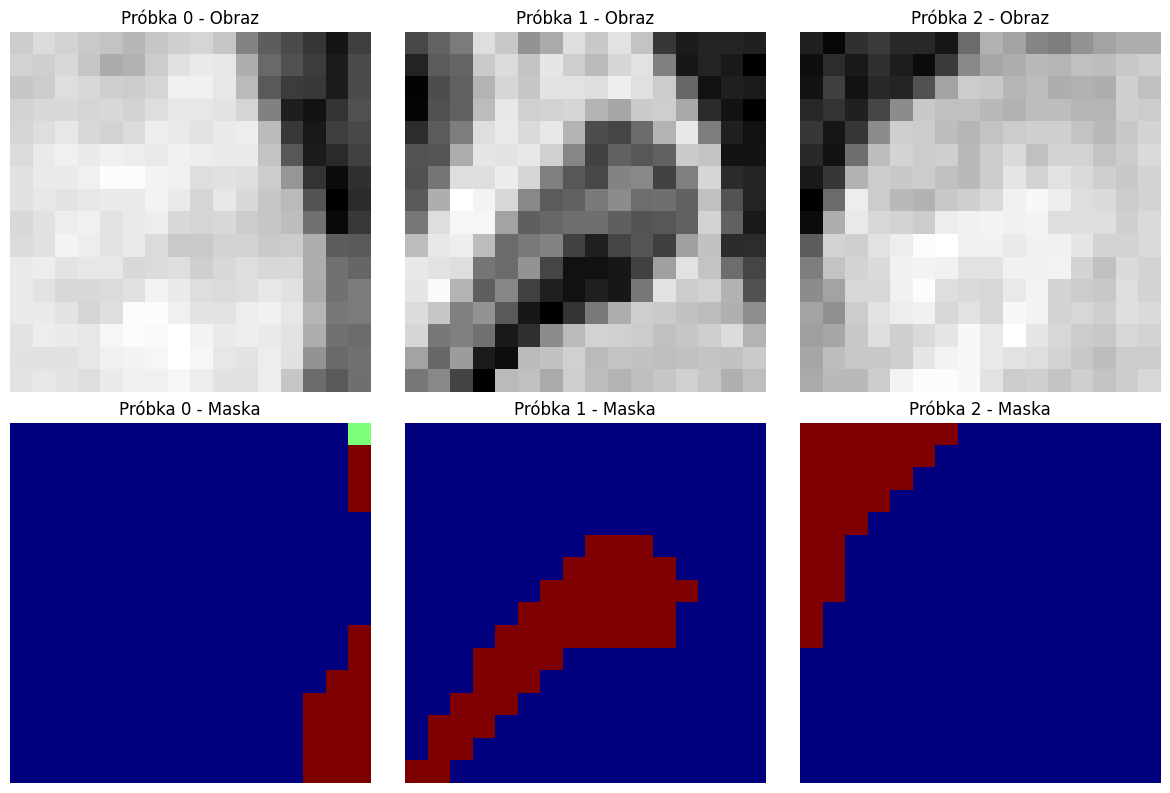

In [3]:
# automatyczne pobranie i przygotowanie zbiorów przez DecathlonDataset
train_ds = DecathlonDataset(root_dir=DATA_ROOT, task=TASK, section="training", transform=train_transforms, download=True, cache_rate=1.0)
val_ds   = DecathlonDataset(root_dir=DATA_ROOT, task=TASK, section="validation", transform=val_transforms, download=True, cache_rate=1.0)
test_ds  = DecathlonDataset(root_dir=DATA_ROOT, task=TASK, section="validation", transform=val_transforms, download=True, cache_rate=1.0)

# Display shape of all the samples in the training dataset
# for i in range(len(val_ds)):
#     print(f"Sample {i} - image shape: {val_ds[i]['image'].shape}, label shape: {val_ds[i]['label'].shape}")

print(f"Zbiory: train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")
# RandCropByPosNegLabeld z num_samples>1 zwraca listę patchy, więc bierzemy pierwszy element
# print("Przykład:", train_ds[0][0]["image"].shape, train_ds[0][0]["label"].shape)

# Wyświetlanie przykładowych próbek treningowych
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i in range(3):
    sample = train_ds[i]
    img = sample[0]["image"][0].cpu().numpy()  # [C, D, H, W] -> [D, H, W]
    label = sample[0]["label"][0].cpu().numpy()
    
    # Środkowy przekrój
    mid_slice = img.shape[0] // 2
    
    # Obraz
    axes[0, i].imshow(img[mid_slice], cmap='gray')
    axes[0, i].set_title(f'Próbka {i} - Obraz')
    axes[0, i].axis('off')
    
    # Maska
    axes[1, i].imshow(label[mid_slice], vmin=0, vmax=NUM_CLASSES-1, cmap='jet')
    axes[1, i].set_title(f'Próbka {i} - Maska')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Zadanie 2 – Implementacja LightningDataModule

W tym zadaniu stworzymy klasę organizującą dostęp do danych zgodnie z konwencją PyTorch Lightning.

1. Zaimplementuj klasę `HippoMonaiDataModule`, która dziedziczy po `pl.LightningDataModule`.
2. Zaimplementuj metodę `__init__` z parametrami: `train_ds`, `val_ds`, `test_ds`, `batch_size`, `num_workers`.
3. Wywołaj konstruktor klasy bazowej: `super().__init__()`.
4. Zapamiętaj wszystkie argumenty.
5. Zaimplementuj metodę `train_dataloader`, która zwraca `DataLoader` dla zbioru treningowego.
6. Zaimplementuj metodę `val_dataloader` analogicznie, ale bez mieszania danych.
7. `test_dataloader` w tym przypadku wskazuje na ten sam zbiór co `val_dataloader`.
8. Stwórz instancję przygotowanej klasy.
9. Pobierz jeden batch z train dataloadera: `b = next(iter(dm.train_dataloader()))`, a następnie sprawdź jego rozmiar. W tym celu wykorzystaj `b["image"]` i `b["label"]`.
10. Zwróć uwagę na wielkość batch'a i czy zgadza się z przewidywaniami.

In [4]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class HippoMonaiDataModule(pl.LightningDataModule):
    def __init__(self, train_ds, val_ds, test_ds, batch_size=8, num_workers=4):
        super().__init__()
        self.train_ds = train_ds
        self.val_ds = val_ds
        self.test_ds = test_ds
        self.batch_size = batch_size
        self.num_workers = num_workers

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def test_dataloader(self):
        # W tym przypadku test = val
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

dm = HippoMonaiDataModule(
    train_ds=train_ds,
    val_ds=val_ds,
    test_ds=test_ds,
    batch_size=BATCH_SIZE,
    num_workers=2
)

b = next(iter(dm.train_dataloader()))
if isinstance(b, list):
    b = b[0] 

print("Batch - image:", b["image"].shape)
print("Batch - label:", b["label"].shape)


Batch - image: torch.Size([8, 1, 16, 16, 16])
Batch - label: torch.Size([8, 1, 16, 16, 16])


## Zadanie 3 – Implementacja V-Net

W tym zadaniu stworzymy architekturę sieci typu V-Net oraz metody potrzebne do jej treningu.

**Część A: Implementacja architektury**

1. Zaimplementuj klasę `ConvBlock3d`, która dziedziczy po `nn.Module`:
   - Konstruktor przyjmuje liczbę kanałów wejściowych i wyjściowych, rozmiar konwolucji, stride i padding.
   - Definiuje: `self.conv` (`nn.Conv3d` bez bias), `self.bn` (`nn.BatchNorm3d`) i funkcję aktywacji (`nn.PReLU`). PReLU różni się od ReLU tym, że zamiast całkowicie zerować wartości ujemne, przepuszcza ich część z uczalnym współczynnikiem α, dzięki czemu neurony rzadziej „umierają”.
   - Metoda `forward` przepuszcza dane wejściowe po kolei przez konwolucję, normalizację, a następnie funkcję aktywacji.

2. Zaimplementuj klasę `UpConvBlock3d`, która dziedziczy po `nn.Module`:
   - Jest ona symetryczna do klasy `ConvBlock3d`, lecz zamiast `nn.Conv3d` stosujemy `nn.ConvTranspose3d`.

3. Zaimplementuj klasę `ResidualBlock3d`, która dziedziczy po `nn.Module`:
   - Konstruktor przyjmuje liczbę kanałów (nie zmienia się ona w tym bloku) i liczbę bloków konwolucyjnych konwolucji.
   - Stwórz listę kolejnych warstw w tym bloku. Pojedynczy element składa się z `nn.Conv3d` (rozmiar konwolucji 3, padding 1), `nn.BatchNorm3d` i `nn.PReLU`. Ich liczba zależna jest od przekazanego parametru.
   - Połącz warstwy z listy za pomocą `nn.Sequential`.
   - W metodzie `forward przepuść dane wejściowe przez zdefiniowany blok. Dodatkowo dodajemy połączenie rezydualne, czyli do wyjścia dodajemy wejście do sieci (nie zmieniamy rozmiaru przestrzennego i liczby warstw, więc rozmiary powinny się zgadzać).

3. Zaimplementuj klasę `VNet3D`, która dziedziczy po `nn.Module`:
   - Konstruktor przyjmuje liczbę kanałów wejściowych, liczbę klas i bazową liczbę kanałów w kolejnych warstwach.
   - **Enkoder:**
     - Składa się on z na zmianę połączonych warstw `ConvBlock3d` i `ResidualBlock3d`. Pierwsza para nie zmniejsza rozdzielczości przestrzennej, tylko zwiększa liczbę kanałów do bazowej.
     - W kolejnych parach rozdzielczość przestrzenna jest zmniejszana przez zastosowanie stride równego 2 w `ConvBlock3d`, natomiast liczba kanałów zwiększana jest dwukrotnie.
     - W kolejnych parach rośnie również liczba bloków w warstwach `ResidualBlock3d`.
     - Stosujemy konwolucje o rozmiarze 3 i padding'u równym 1.
   - **Dekoder:**
     - Składa się on z na zmianę połączonych warstw `UpConvBlock3d` i `ResidualBlock3d`.
     - W kolejnych parach rozdzielczość przestrzenna jest zwiększana, natomiast liczba kanałów jest zmniejszana.
     - Zmniejsza się również liczba bloków w warstwach `ResidualBlock3d` dla kolejnych par.
     - W blokach `UpConvBlock3d` stosujemy konwolucje o rozmiarze 2, stride równym 2, a padding równym 0.
     - Na koniec liczbę kanałów zmniejszamy do liczby klas za pomocą `nn.Conv3d` o rozmiarze 1.
   - Metoda `forward`:
     - Najpierw przepuszczamy dane wejściowe przez kolejne warstwy enkodera.
     - Dla dekodera musimy dodać również połączenia z enkodera.
     - Zamiasat konkatenacji kanałów w V-Net stosujemy dodawanie.
     - Dla wyjścia z każdego bloku `UpConvBlock3d` dodajemy wyjście z odpowiadającego bloku `ConvBlock3d` w enkoderze.

**Część B: Implementacja treningu**

1. Zaimplementuj klasę `LitVNet`, która dziedziczy po `LightningModule`:
   - Konstruktor przyjmuje liczbę kanałów wejściowych, liczbę klas i learning rate.
   - Wywołaj `super().__init__()` oraz `self.save_hyperparameters()`
   - Stwórz instancję zaimplementowanej wcześniej sieci.
   - Zdefiniuj funkcję straty `DiceCELoss(to_onehot_y=True, softmax=True, squared_pred=False, include_background=True, lambda_dice=1.0, lambda_ce=1.0)`
   - Zdefiniuj metryki:
     - Dice: `DiceMetric(include_background=True, reduction="mean", get_not_nans=False)`
     - IoU: `MulticlassJaccardIndex(num_classes=out_channels, average="macro")`

2. Zaimplementuj metodę `forward(self, x)` zwracającą wyjście sieci.

6. Zaimplementuj metodę `configure_optimizers`:
   - Pptymalizator Adam: `torch.optim.Adam(self.parameters(), lr=self.hparams.lr)`
   - Scheduler cosinusowy: `torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)`
   - Zwróć słownik: `{"optimizer": opt, "lr_scheduler": sch}`

7. Zaimplementuj metody `training_step`, `validation_step` i `test_step`:
   - Pobierz dane: `batch["image"]` `batch["label"].long()`.
   - Oblicz predykcje: `self(x)`.
   - Oblicz stratę.
   - W bloku `with torch.no_grad():` oblicz metryki:
     - `preds = torch.argmax(logits, dim=1)`
     - Konwersja do one-hot dla metryki Dice:
       - `y_oh = [AsDiscrete(to_onehot=self.hparams.out_channels)(yy) for yy in decollate_batch(y)]`
       - `p_oh = [AsDiscrete(argmax=True, to_onehot=self.hparams.out_channels)(pp) for pp in decollate_batch(logits)]`
     - `decollate_batch` dzieli batch na listę pojedynczych próbek, co jest wymagane przez niektóre metryki MONAI
     - Oblicz Dice: `self.dice_metric(y_pred=p_oh, y=y_oh)`; `dice = self.dice_metric.aggregate().item()`; `self.dice_metric.reset()`
     - Oblicz mIoU: `miou = self.miou_metric(preds, y.squeeze(1))`
   - Zaloguj metryki:
     - `self.log(f"{stage}_loss", loss, on_epoch=True, prog_bar=True)`
     - `self.log(f"{stage}_dice", dice, on_epoch=True, prog_bar=(stage!='train'))`
     - `self.log(f"{stage}_miou", miou, on_epoch=True, prog_bar=(stage!='train'))`
   - Zwróć `loss` dla metody `training_step`

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete
from monai.data import decollate_batch

from torchmetrics.classification import MulticlassJaccardIndex


class ConvBlock3d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm3d(out_channels)
        self.act = nn.PReLU(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x


class UpConvBlock3d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2, padding=0):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=kernel_size,
                                     stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm3d(out_channels)
        self.act = nn.PReLU(out_channels)

    def forward(self, x):
        x = self.up(x)
        x = self.bn(x)
        x = self.act(x)
        return x


class ResidualBlock3d(nn.Module):
    def __init__(self, channels, n_convs=2):
        super().__init__()
        layers = []
        for _ in range(n_convs):
            layers.append(nn.Conv3d(channels, channels, kernel_size=3, padding=1, bias=False))
            layers.append(nn.BatchNorm3d(channels))
            layers.append(nn.PReLU(channels))
        self.seq = nn.Sequential(*layers)

    def forward(self, x):
        out = self.seq(x)
        return out + x


class VNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, base_filters=16, depth=4):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.base = base_filters
        self.depth = depth

        enc_convs = []
        enc_res = []

        prev_ch = in_channels
        ch = self.base

        enc_convs.append(ConvBlock3d(prev_ch, ch, kernel_size=3, stride=1, padding=1))
        enc_res.append(ResidualBlock3d(ch, n_convs=1))
        prev_ch = ch

        for lvl in range(1, self.depth):
            ch = self.base * (2 ** lvl)
            enc_convs.append(ConvBlock3d(prev_ch, ch, kernel_size=3, stride=2, padding=1))
            enc_res.append(ResidualBlock3d(ch, n_convs=1 + lvl))
            prev_ch = ch

        self.enc_convs = nn.ModuleList(enc_convs)
        self.enc_res = nn.ModuleList(enc_res)

        dec_ups = []
        dec_res = []
        for lvl in range(self.depth - 1, 0, -1):
            in_ch = self.base * (2 ** lvl)
            out_ch = self.base * (2 ** (lvl - 1))
            dec_ups.append(UpConvBlock3d(in_ch, out_ch, kernel_size=2, stride=2, padding=0))
            dec_res.append(ResidualBlock3d(out_ch, n_convs=1 + (lvl - 1)))

        self.dec_ups = nn.ModuleList(dec_ups)
        self.dec_res = nn.ModuleList(dec_res)

        self.final_conv = nn.Conv3d(self.base, out_channels, kernel_size=1)

    def forward(self, x):
        enc_feats = []

        out = x
        for conv, res in zip(self.enc_convs, self.enc_res):
            out = conv(out)
            out = res(out)
            enc_feats.append(out)

        for i, (up, res) in enumerate(zip(self.dec_ups, self.dec_res)):
            out = up(out)
            enc_to_add = enc_feats[-(2 + i)]
            if out.shape != enc_to_add.shape:
                enc = enc_to_add
                _, _, d1, h1, w1 = enc.shape
                _, _, d2, h2, w2 = out.shape
                sd = (d1 - d2) // 2
                sh = (h1 - h2) // 2
                sw = (w1 - w2) // 2
                if sd >= 0 and sh >= 0 and sw >= 0:
                    enc = enc[:, :, sd:sd + d2, sh:sh + h2, sw:sw + w2]
                else:
                    pad_d = max(0, d2 - d1)
                    pad_h = max(0, h2 - h1)
                    pad_w = max(0, w2 - w1)
                    pad = (pad_w//2, pad_w - pad_w//2,
                           pad_h//2, pad_h - pad_h//2,
                           pad_d//2, pad_d - pad_d//2)
                    enc = F.pad(enc, pad)
                enc_to_add = enc
            out = out + enc_to_add
            out = res(out)

        logits = self.final_conv(out)
        return logits


class LitVNet(pl.LightningModule):
    def __init__(self, in_channels, out_channels, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = VNet3D(in_channels, out_channels)
        self.loss_fn = DiceCELoss(to_onehot_y=True, softmax=True)
        self.dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
        self.miou_metric = MulticlassJaccardIndex(num_classes=out_channels, average="macro")

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
        return {"optimizer": opt, "lr_scheduler": sch}

    def shared_step(self, batch, stage: str):
        if isinstance(batch, list):
            batch = batch[0]
        if isinstance(batch, (list, tuple)):
            x, y = batch
        else:
            x = batch["image"]
            y = batch["label"]

        y = y.long()
        if y.ndim == 4:
            y = y.unsqueeze(1)

        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log(f"{stage}_loss", loss, on_epoch=True, prog_bar=True)

        with torch.no_grad():
            preds = torch.argmax(logits, dim=1, keepdim=True)

            y_oh = torch.nn.functional.one_hot(y.squeeze(1), num_classes=self.hparams.out_channels)
            y_oh = y_oh.permute(0, 4, 1, 2, 3).float()

            p_oh = torch.nn.functional.one_hot(preds.squeeze(1), num_classes=self.hparams.out_channels)
            p_oh = p_oh.permute(0, 4, 1, 2, 3).float()

            y_list = [yy for yy in y_oh]
            p_list = [pp for pp in p_oh]

            # DiceMetric (MONAI)
            self.dice_metric(y_pred=p_list, y=y_list)
            dice = self.dice_metric.aggregate().item()
            self.dice_metric.reset()

            # IoU
            self.miou_metric(preds, y)
            miou = self.miou_metric.compute().item()
            self.miou_metric.reset()

            self.log(f"{stage}_dice", dice, on_epoch=True, prog_bar=True)
            self.log(f"{stage}_miou", miou, on_epoch=True, prog_bar=True)

        return loss




    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        self.shared_step(batch, "val")

    def test_step(self, batch, batch_idx):
        self.shared_step(batch, "test")

## Zadanie 4 – Trening

1. Stwórz instancję modelu.
2. Skonfiguruj callback `EarlyStopping`.
3. Skonfiguruj callback `ModelCheckpoint`.
4. Stwórz `Trainer`. Przekaż liczbę epok, callbacki i częstotliwość logowania `log_every_n_steps=5`.
5. Uruchom trening metodą `fit`.
6. Wczytaj najlepszy model metodą `load_from_checkpoint`.
7. Uruchom ewaluację na zbiorze testowym: `trainer.test(best, datamodule=dm)`.

In [12]:
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

model = LitVNet(
    in_channels=1,
    out_channels=NUM_CLASSES,
    lr=1e-4
)

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min"
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="./checkpoints",
    filename="vnet3d-{epoch:02d}-{val_loss:.4f}",
    save_top_k=1,
    mode="min"
)

trainer = Trainer(
    max_epochs=50,
    log_every_n_steps=5,
    callbacks=[early_stop_callback, checkpoint_callback],
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None
)

trainer.fit(model, datamodule=dm)

best_ckpt_path = checkpoint_callback.best_model_path
print(f"Best checkpoint: {best_ckpt_path}")

best_model = LitVNet.load_from_checkpoint(best_ckpt_path)

trainer.test(best_model, datamodule=dm)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/karolina/studia/piaom/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /home/karolina/studia/piaom/lab6/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                   | Params | Mode 
---------------------------------------------------------------
0 | model       | VNet3D                 | 2.9 M  | train
1 | loss_fn     | DiceCELoss             | 0      | train
2 | miou_metric | MulticlassJaccardIndex | 0      | train
---------------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.754    Total estimated model params size (MB)
101       Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 26/26 [00:02<00:00, 11.04it/s, v_num=12, train_loss_step=0.851, train_dice_step=0.684, train_miou_step=0.587, val_loss=0.584, val_dice=0.840, val_miou=0.743, train_loss_epoch=0.777, train_dice_epoch=0.777, train_miou_epoch=0.680]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 26/26 [00:02<00:00, 11.03it/s, v_num=12, train_loss_step=0.851, train_dice_step=0.684, train_miou_step=0.587, val_loss=0.584, val_dice=0.840, val_miou=0.743, train_loss_epoch=0.777, train_dice_epoch=0.777, train_miou_epoch=0.680]
Best checkpoint: /home/karolina/studia/piaom/lab6/checkpoints/vnet3d-epoch=48-val_loss=0.5745.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 71.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_dice           0.8417545557022095
        test_loss           0.5744926333427429
        test_miou           0.7486776113510132
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5744926333427429,
  'test_dice': 0.8417545557022095,
  'test_miou': 0.7486776113510132}]

## Zadanie 5 – Inferencja na pełnym wolumenie i wizualizacja

W tym zadaniu wykonamy predykcję na pełnym wolumenie MRI i zwizualizujemy wyniki.

1. Przełącz wczytany model w tryb ewaluacji i przenieś na odpowiednie urządzenie.
2. Pobierz pierwszy przypadek ze zbioru testowego: `case = dm.test_ds[0]`.
3. Przygotuj wolumen do inferencji:
   - Pobierz obraz: `case["image"]`
   - Dodaj wymiar batch: `.unsqueeze(0)`
   - Przenieś na urządzenie modelu: `.to(best.device)`
4. Pobierz ground truth: `gt = case["label"].squeeze(0).cpu().numpy()`.
5. W bloku `with torch.no_grad():` wykonaj inferencję:
   - Użyj `sliding_window_inference` z parametrami:
     - `vol` - wejściowy wolumen,
     - `roi_size=ROI_SIZE` - rozmiar okna przesuwnego,
     - `sw_batch_size=BATCH_SIZE` - liczba okien przetwarzanych jednocześnie,
     - `predictor=best` - model do predykcji,
     - `overlap=0.5` - nakładanie się okien (50%).
     - Funkcja `sliding_window_inference` dzieli wolumen na nakładające się okna o zadanym rozmiarze i przetwarza je partiami przez podany model. Predykcje z poszczególnych okien są następnie uśredniane, aby otrzymać spójną predykcję dla całego wolumenu.
6. Konwertuj logity na predykcje klas: `pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()`.
8. Stwórz wizualizację z trzema środkowymi przekrojami:
   - Oryginalny obraz MRI,
   - Maska (GT),
   - Predykcja.

/home/karolina/studia/piaom/venv/lib/python3.12/site-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/home/karolina/studia/piaom/venv/lib/python3.12/site-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autog

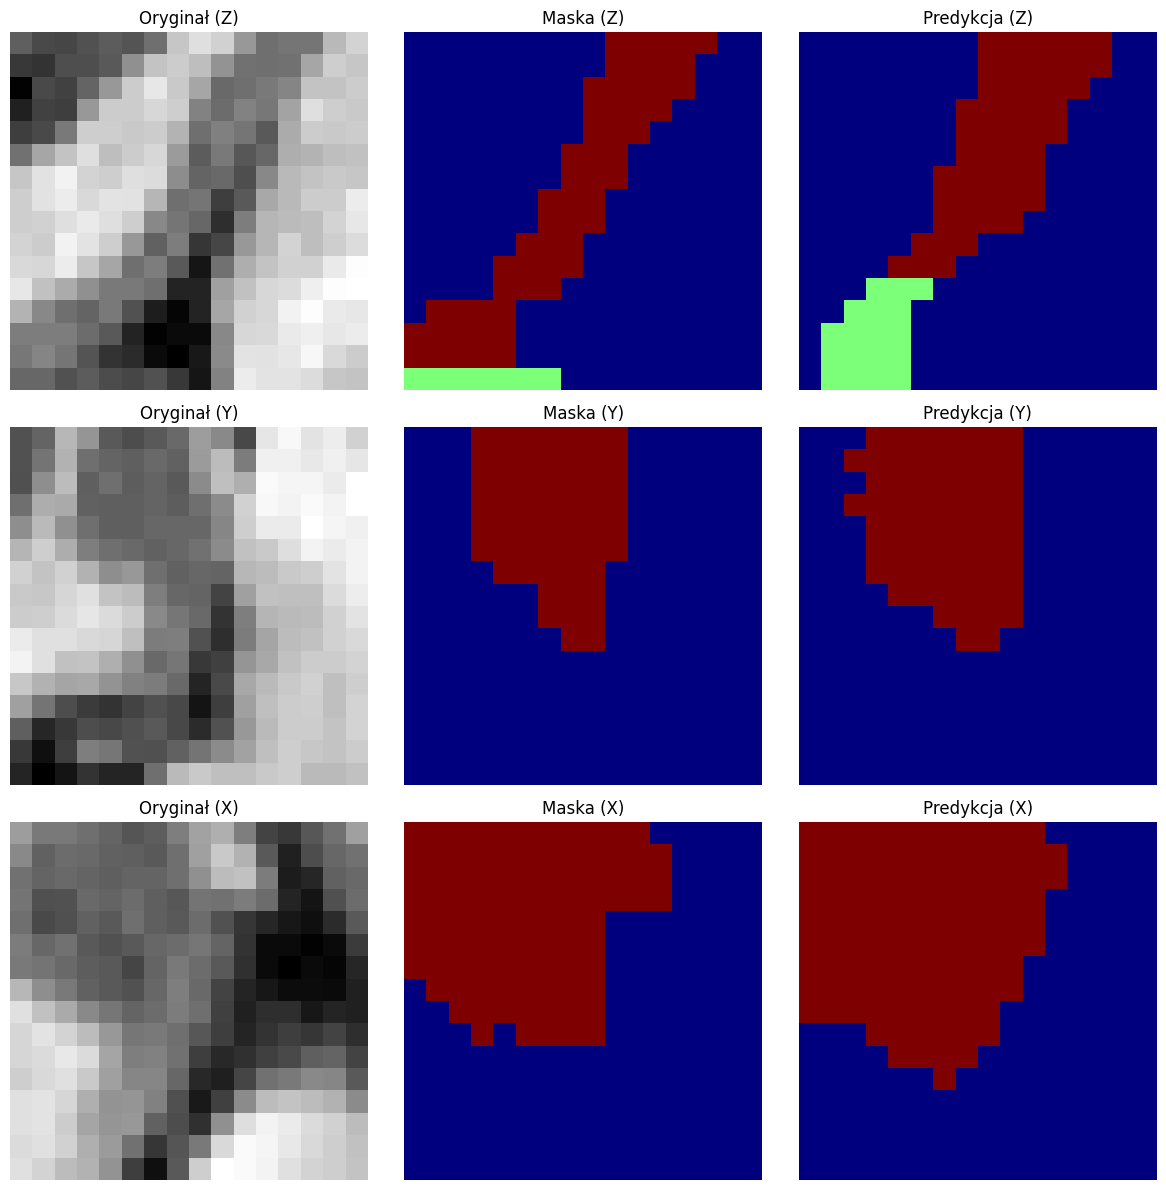

In [13]:
import torch
import matplotlib.pyplot as plt
from monai.inferers import sliding_window_inference

best_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

case = dm.test_ds[0]

vol = case["image"].unsqueeze(0).to(device)
gt = case["label"].squeeze(0).cpu().numpy()

with torch.no_grad():
    logits = sliding_window_inference(
        inputs=vol,
        roi_size=ROI_SIZE,
        sw_batch_size=BATCH_SIZE,
        predictor=best_model,
        overlap=0.5
    )

pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()
img = vol.squeeze(0).squeeze(0).cpu().numpy()

d, h, w = img.shape
slices = [d // 2, h // 2, w // 2]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

axes[0, 0].imshow(img[slices[0], :, :], cmap="gray")
axes[0, 0].set_title("Oryginał (Z)")
axes[0, 1].imshow(gt[slices[0], :, :], cmap="jet", vmin=0, vmax=NUM_CLASSES-1)
axes[0, 1].set_title("Maska (Z)")
axes[0, 2].imshow(pred[slices[0], :, :], cmap="jet", vmin=0, vmax=NUM_CLASSES-1)
axes[0, 2].set_title("Predykcja (Z)")

axes[1, 0].imshow(img[:, slices[1], :], cmap="gray")
axes[1, 0].set_title("Oryginał (Y)")
axes[1, 1].imshow(gt[:, slices[1], :], cmap="jet", vmin=0, vmax=NUM_CLASSES-1)
axes[1, 1].set_title("Maska (Y)")
axes[1, 2].imshow(pred[:, slices[1], :], cmap="jet", vmin=0, vmax=NUM_CLASSES-1)
axes[1, 2].set_title("Predykcja (Y)")

axes[2, 0].imshow(img[:, :, slices[2]], cmap="gray")
axes[2, 0].set_title("Oryginał (X)")
axes[2, 1].imshow(gt[:, :, slices[2]], cmap="jet", vmin=0, vmax=NUM_CLASSES-1)
axes[2, 1].set_title("Maska (X)")
axes[2, 2].imshow(pred[:, :, slices[2]], cmap="jet", vmin=0, vmax=NUM_CLASSES-1)
axes[2, 2].set_title("Predykcja (X)")

for ax in axes.flatten():
    ax.axis("off")

plt.tight_layout()
plt.show()


---

## Podsumowanie i wnioski

Odpowiedz krótko na poniższe pytania.

1. Co oznacza ROI_SIZE w przypadku segmentacji 3D jak w wykonanym ćwiczeniu?
2. Wyjaśnij parametry SAMPLES_PER_VOLUME i POS_NEG_RATIO.
3. W jaki sposób V-Net różni się od U-Net (np. sposób łączenia ścieżek enkodera/dekodera)?
4. Jak działa sliding_window_inference i jaki wpływ ma parametr overlap na jakość predykcji?